In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, Binarizer, StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.metrics import average_precision_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA, SparsePCA 
from joblib import Parallel, delayed
import itertools
%matplotlib inline

# Capital loss prevention : loan outcome prediction

In [2]:
def my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler()):
    ''' Transform features using a column transformer. 
    
    A DataFrame which takes mixed "Missing" and datetime values, separates out the "Missing"
    and then performs two operations. First, the 'Missing' column is one-hot encoded, second,
    the datetime variables are binned and encoded using KBinsDiscretizer, using a uniform bin
    width strategy. 

    Parameters
    ----------

    X : DataFrame (n_samples, n_features)
         
        Dataframe which contains training data. 

    num_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain numerical features.
         

    cat_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
    date_features : list, Pandas index
    
        List of Pandas Index of the name of columns that contain categorical features.
         
        Dataframe which contains datetime features and value "Missing" which indicates missing values.

    num_transformer : scikit-learn Transformer
         
        scikit-learn scaler such as QuantileTransformer(), MinMaxScaler(), etc.

    Returns
    -------

    col_transformer : ColumnTransformer instance
    
         Transformer that can be used to rescale and encode data. 
            
    '''
    
    transformer_list = []
    if num_transformer is not None:
        transformer_list += [('num', num_transformer, num_features)] 

    if cat_features is not None:        
        #uniq_categories = [list(np.sort(X[col].unique()))+['Missing','Unknown'] for col in cat_features]
        uniq_categories = [list(np.sort(X[col].unique())) for col in cat_features]
        # Previously dropped first category, this is more strategic.
        least_populated_categories = [X[col].value_counts().idxmin() for col in cat_features]
        cat_transformer = OneHotEncoder(categories=uniq_categories, drop=least_populated_categories)
        transformer_list += [('cat', cat_transformer, cat_features)] 
        
    if date_features is not None:             
        transformer_list += [('my_kbd', 'passthrough', date_features)] 

    col_transformer = ColumnTransformer(transformers=transformer_list)

    return col_transformer


# Function that combines different classification metrics to avoid repeated large blocks of code.
# Produces the confusion matrix, classification report (precision, recall, f1-score,..)
# ROC-AUC and ROC curve
# Precision-recall curve

def my_score(clf, X_test, y_test):
    ''' Predict using trained scikit-learn estimator and compute the explained variance score.  

    Parameters
    ----------
    X_test : ndarray or DataFrame (n_samples, n_features)
             Feature data to test. n_features represents the number of features
             present in the data used to train the estimator clf

    y_test : ndarray (n_samples, )
             Target data to test. 


    clf : scikit-learn estimator which has been fit to data with same number of columns as X_test

    '''
    y_predict_proba= clf.predict_proba(X_test)[:,1]
    return roc_auc_score(y_test, y_predict_proba)


def classifier_analysis(clf, xt, yt):
    ''' Predict and measure quality of model with a variety of metrics.   

    Parameters
    ----------

    xt : ndarray or DataFrame (n_samples, n_features)
             Feature data to test. n_features represents the number of features
             present in the data used to train the estimator clf

    yt : ndarray (n_samples, )
             Target data to test. 


    clf : scikit-learn estimator which has been fit to data with same number of columns as X_test

    '''
    y_predict = clf.predict(xt)
    y_predict_proba= clf.predict_proba(xt)[:,1]

    cm = confusion_matrix(yt, y_predict, labels=[0,1])#,dtype=float)
    # negative guesses
#     cm[:, 0] = cm[:, 0] / (len(yt) - yt.sum())
#     cm[:, 1] = cm[:, 1] / yt.sum()
    print('tn, fp, fn, tp', cm.ravel())
    _ = ConfusionMatrixDisplay(cm / (yt.size), [0,1]).plot()
    
    print(classification_report(yt, y_predict))

    roc_auc = roc_auc_score(yt, y_predict_proba)
    fpr, tpr, thresholds = roc_curve(yt, y_predict_proba)

    plt.figure()
    plt.plot(fpr, tpr, label=(clf.__class__.__name__ + '(area = %0.2f)' % roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    average_precision = average_precision_score(yt, y_predict_proba)
    precision, recall, thresholds = precision_recall_curve(yt, y_predict_proba)
    disp = plot_precision_recall_curve(clf, xt, yt)
    disp.ax_.set_ylim([0.0, 1.0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))
    plt.show()
    
    return roc_auc



def scale_features(col_transformer_, X_train, X_test):
    _ = col_transformer_.fit(X_train)
    X_train = col_transformer_.transform(X_train)
    X_test = col_transformer_.transform(X_test)
    return X_train, X_test

In [3]:
def fit_model_(estimator, X_traintest, y_traintest, train, test):
    num_features = X_traintest.select_dtypes(exclude=['object','category']).columns
    cat_features = X_traintest.select_dtypes(include=['object','category']).columns
    date_features = None
    
    X_train, X_test = X_traintest.loc[train,:], X_traintest.loc[test,:]
    y_train, y_test = y_traintest.loc[train].values.ravel(), y_traintest.loc[test].values.ravel()
    
    col_transformer_ = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())
    X_train, X_test  = scale_features(col_transformer_, X_train, X_test)
    
    _ = estimator.fit(X_train, y_train)    
    return (estimator, X_test, y_test)

def param_grid_iterable(params):
    keys = sorted(params)
    combinations = list(itertools.product(*(params[key] if type(params[key]) in [list, dict, np.ndarray] else [params[key]]
                                            for key in keys)))
    cvsorted = [dict(zip(len(c)*keys, c)) for c in combinations]
    return cvsorted

def my_cross_validate(estimator, X_traintest, y_traintest, train_test_iterable, param_grid, n_jobs=-2):
    mean_scores = []
    # cv_params needs to make sense for the estimator given
    param_grid_list = param_grid_iterable(param_grid)
    for params_ in param_grid_list:
        with Parallel(n_jobs=n_jobs, max_nbytes=None) as parallel:
            fitted_models_and_test_splits = parallel(delayed(fit_model_)(estimator(**params_), 
                                                          X_traintest, y_traintest, train, test)
                                  for (train, test) in train_test_iterable)
            
        with Parallel(n_jobs=n_jobs, max_nbytes=None) as parallel:
            fitted_models_and_test_splits = parallel(delayed(fit_model_)(estimator(**params_), 
                                                          X_traintest, y_traintest, train, test)
                                  for (train, test) in train_test_iterable)
            # Get averages (explained variance) score for this model
            scores = parallel(delayed(my_score)(model_, xt, yt) for (model_, xt, yt) in fitted_models_and_test_splits) 
            mean_scores += [np.mean(list(scores))]
            
    
    best_params_ = param_grid_list[np.argmax(np.array(mean_scores))]
    return estimator(**best_params_) 


# Convert date-like + 'Missing' valued features to one-hot encoded columns; uses KBins on the years of the date-like, which 
# bins then one-hot encodes, while also one-hot encoding 'Missing' separately. 
def encode_dates_and_missing(df):
    for i, seriesname in enumerate(df.columns):
        series = df[seriesname]
        series_missing = pd.get_dummies(series[series=='Missing'])
        series_notmissing = series[series!='Missing']
        notmiss_index = series_notmissing.index
        
        kbd = KBinsDiscretizer(n_bins=5, strategy='uniform')
        series_dt = pd.to_datetime(series_notmissing).dt.year
        encoded_series = kbd.fit_transform(series_dt.values.reshape(-1,1))
        encoded_series = pd.DataFrame(kbd.fit_transform(series_dt.values.reshape(-1,1)).toarray(),index=notmiss_index).astype(int)
        least_populated_feature = np.array([encoded_series[col].sum() for col in encoded_series.columns]).argmin()
        encoded_series = encoded_series.drop(columns=encoded_series.columns[least_populated_feature])
        encoded_series.columns = [seriesname+'_'+str(col) for col in encoded_series.columns]
        if i == 0: 
            encoded_df = encoded_series
        else:
            encoded_df = pd.concat((encoded_df,encoded_series),axis=1)
            
    return encoded_df


Need to take into consideration the time dependence element of this problem. The original goal is to create a predictive model that attempts to determine whether or not to issue a loan based on the learning what factors are likely to lead to a charged-off (defaulted) loan. Before we can begin there are a number of considerations that need to be performed first before the actually modeling process can begin. The necessary actions that must be taken are

    1. Accounting for the time dependent nature of this problem.
    2. Handling heterogeneous data types and preprocessing
    4. Deciding on the model to be used, both in terms of hyperparameters and algorithms
    5. Accounting for any unexpected results.
    6. Analysis of the chosen model.

In [4]:
# Import the data that has been prepared for this problem.
loan_data = pd.read_csv('../data/classification_loan_data_ind.csv', index_col=False)

For the loan outcome prediction portion of this project, only the loans which have both matured are considered.
Additionally, in this subset of loans there are a number of outcomes but by far the most highly populated are loans which have been fully paid or charged off. This can be formulated as a binary classification problem: the loans that are charged-off
will be denoted as "successes" or by the integer 1. Likewise, loans which have been fully paid off will be denoted as "failure"
by assigning these the integer 0. 

## 1. Time-dependency
The first main hurdle that we need to overcome is the time dependent nature of the problem. If not handled carefully, we could accidentally perform what is known as "data snooping", which is the contamination of the model by inclusion of information from
the future. The two main effects that this time dependency has are
 
- Multiple time dependent variables
- Time ordered cross validation folds

To account for the first of these issues, all variables that are recorded at times more recent than the issuance date
of the loan are removed. The features which are removed all involve measurements in the recent past or present such as "in the past twelve months". Some of the features are ambiguous and so we lean on the side of caution by removing these features as well. By including only loans which have matured, the correct description that these models produce is **predict whether a loan will default by the maturity date**. The maturity date depends on the term of the loan; it might be wise to separate the loans by term but currently this is not done.

To handle the second of these bullet points, the cross validation process as well as the folds will be customly made, instead
of using scikit-learn's TimeSeriesSplit() for instance. This is to be as confident as possible that there is no data snooping. Additionally, there are some considerations regarding encoding and preprocessing that are best handled by a custom cross-validation procedure.

In [5]:
# This step will be deprecated after newest data cleaning run. 
issued_datetime = pd.to_datetime(loan_data.issue_d, format='%b-%Y').sort_values()
loan_data = loan_data.loc[issued_datetime.sort_values().index,:]

Have the cross validation folds, now need to create procedure which correctly preprocesses them before testing. Training component of folds are cumulative over time; always want to use as much information as possible.

Create a "hold-out" set of data that will used for final predictions and analysis after all cross-validation and
model learning has been accomplished. The loan issuance dates are aggregated by month, but from the metadata we know that the data is reported *quarterly*. Using this as motivation, the hold-out data will be the most recent quarter. Because the number of loans has grown over time, this one quarter represents nearly $1 / 7$ of all loan data of loans that have either been fully paid or charged off.

In [6]:
# Data goes from second quarter of 2007 to fourth quarter of 2015; the number of samples are skewed toawrds later dates;
# The data is reported quarterly; this should be represented in the cross validation/model selection process.
pind = pd.PeriodIndex(issued_datetime, freq='M')

KBins needs numerical variables; use year.quarter (number.decimal). This transformation is not applied to the training data; it's just used

In [7]:
# Forget quarters, use month and year
numerical_dt = 12*(pind.year-pind.year.min()) + pind.month

nb=6
kbd = KBinsDiscretizer(n_bins=nb)
bin_masks = kbd.fit_transform(numerical_dt.values.reshape(-1, 1)).toarray()

Size of the cross-validation folds

In [8]:
np.sum(bin_masks, axis=0)

array([76780., 87727., 64957., 88374., 95477., 85483.])

## 2. Heterogeneous data types

Strictly speaking there are two different data types in the feature data, numerical (float) and categorical (object, could be
cast as string). The categorical variables will be encoded and represented by binary numerical columns. Practically speaking it gets more detailed; some of the categorical variables have many categories, of
the order of a thousand. Let's have a look to see how we should proceed.

In [9]:
loan_data.select_dtypes(include='object').nunique()

grade                    7
sub_grade               35
emp_length              12
home_ownership           6
issue_d                 41
purpose                 14
zip_code               907
addr_state              51
term                     2
earliest_cr_line       676
initial_list_status      2
dtype: int64

The most diverse categorical variables will be handled in one of two ways: we shall argue that they are
either unnecessary or reduce the number of categories via binning.
The following are the choices made for these variables: originally the choice was made to remove all but the first two digits
of the zip_code (there are only three recorded). This in fact lowers the resolution to a point where the state of residence is more precise; therefore, I believe that the zip_code can be dropped as it isn't informative. For the categorical variables which may be cast as datetime variables, **['earliest credit_line', 'issue_d']** the number of categories will be reduces by application of a binning strategy. The binning for the issuance date is naturally handled when the cross-validation folds are
being produced, as this is the determining time dependent quantity. More specifically, we drop the issuance date from the calculation because based on the folds, the training and testing data will never intersect by definition; which I believe implies that the model will not know what to do. For the earliest_credit_line dates it is less obvious as how to proceed. The earliest credit line is thought of to be a proxy for age groups. Depending on the context, demographic age groups can be quite large in terms of the age spread. Therefore, I believe that only creating a few bins for this variable is
sufficient. Applying the same argument comparing zip_code and addr_state, I remove the 'grade' of the loan in favor of keeping the subgrade. The grades take the values such as 'A', 'B', 'C' while the sub-grade is more specific 'A1', 'A2', ... 'E4', 'E5'.
Therefore before the modeling process the following steps shall be taken:

    1. Remove target variable from feature data
    2. Remove more coarse categorical variables
    3. Encode datetime-like categorical variables with KBinsDiscretizer (OneHotEncoding strategy).
    4. Encode remaining categorical variables with OneHotEncoder (scitkit-learn)
    
Note: To avoid colinearity in the one-hot encoding process, the category with the lowest frequency is dropped (for each feature).

In [10]:
# Remove target variable
y = loan_data.loan_status.astype(int)
# Dump everything with high correlations
X = loan_data.drop(columns=['loan_status', 'zip_code', 'issue_d', 'earliest_cr_line', 'grade'])#,'funded_amnt','installment'])
num_features = X.select_dtypes(include='number').columns
cat_features = X.select_dtypes(include=['object','category']).columns
date_features = ['earliest_cr_line']
encoded_dates = encode_dates_and_missing(loan_data.loc[:, date_features])
date_features = encoded_dates.columns
X = pd.concat((X, encoded_dates),axis=1)
X = X.reset_index(drop=True)
y.index = X.index

Scikit-learn wants iterable containing (train_indices, test_indices)

In [11]:
train_indices = np.array([np.array(X.index[
    np.array(np.sum(bin_masks[:, :i+1],axis=1), dtype=bool)].tolist())
                          for i in range(bin_masks.shape[1]-2)])
test_indices = np.array([np.array(X.index[
    np.array(bin_masks[:,i+1], dtype=bool)].tolist())
                         for i in range(bin_masks.shape[1]-2)])

train_test_iterable = list(zip(train_indices,test_indices))

traintest_indices = X.index[np.array(np.sum(bin_masks[:,:-1],axis=1), dtype=bool)] 
holdout_indices = X.index[np.array(bin_masks[:, -1], dtype=bool)] 

In [12]:
col_transformer = my_feature_transformer(X, num_features, cat_features, date_features, num_transformer=StandardScaler())
X_traintest, X_holdout = X.loc[traintest_indices, :], X.loc[holdout_indices, :]
y_traintest, y_holdout = y.loc[traintest_indices], y.loc[holdout_indices]

X_traintest = X_traintest.reset_index(drop=True)
X_holdout = X_holdout.reset_index(drop=True)

_ = col_transformer.fit(X_traintest)
X_traintest_transform = col_transformer.transform(X_traintest)
X_holdout_transform = col_transformer.transform(X_holdout)

## 4. Model selection
First, perform preliminary tests to
develop an intuition as what to include in the cross-validation process. To
do so, the data needs to be processed and transformed. There are a number of choices for the
method with which to scale the numerical data. The tests are performed by using the entirety
of the training data (named traintest because the testing folds come from this subset) to fit
the model. The model is then tested using this data as well as a set of "holdout" data which
the model does not know about. The holdout data, by virtue of the cross-validation folds,
corresponds to the most recent loan data. 

The name for the data variables might be confusing so, to be explicit:

"traintest" is the data such that for each cross validation fold, traintest is split into a training set
and a testing set. After the model selection via cross-validation the "traintest" set becomes the
final training set.

"holdout" is the data completely unknown to the model which is only tested after absolutely everything is
put into place. 

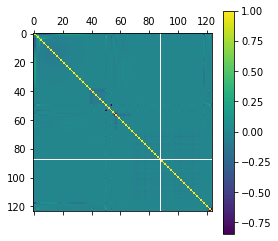

In [13]:
#Quick test of collinearity via correlation matrix plot
plt.matshow(pd.DataFrame(X_traintest_transform.toarray()).corr(), cmap='viridis')
_ = plt.colorbar()
_ = plt.show()

To begin the modeling process, first I would like to get an idea with what I am working with by fitting the models without parameter tuning. 

In [ ]:
logistic_regression = LogisticRegression()
_ = logistic_regression.fit(X_traintest_transform, y_traintest.values)

In [ ]:
print('Logistic Regression evaluation on training set')
_ = classifier_analysis(logistic_regression, X_traintest_transform, y_traintest.values)

In [ ]:
print('Logistic Regression evaluation on testing set')
logreg_roc_auc_test = classifier_analysis(logistic_regression, X_holdout_transform, y_holdout.values)

In [ ]:
random_forest_initial = RandomForestClassifier()
_ = random_forest_initial.fit(X_traintest_transform, y_traintest.values)

In [ ]:
print('Random Forest evaluation on training set')
_ = classifier_analysis(random_forest_initial, X_traintest_transform, y_traintest.values)

In [ ]:
print('Random Forest evaluation on testing set')
random_forest_initial_roc_auc = classifier_analysis(random_forest_initial, X_holdout_transform, y_holdout.values)

For me there are two main takeaways from these tests. Firstly, the class weights need to be balanced to represent the frequency at which defaults occur (approximately 1/7 of the total samples).  

The main goal is to reduce capital loss not maximize profits. Therefore, we value prediction of when a loan will be charged off more than fully paid. We can account for this by changing the class weights in the classification process. This model will reject loans that would have been fully paid in order to avoid loans that will become charged off. In other words, the goal is to maximize the number of true positives, where "positive" in this case is equivalent to a loan being charged off.
It's clear that the class weights need to be balanced because otherwise the models are modeling the null information rate.
Therefore, for everything that proceeds I shall weight the binary classes by their inverse frequency.
The choices for the hyper-parameters aren't obvious so the cross-validation process attempts to cast a broad (but coarse) net
on the hyper-parameter space.   

In [17]:
n_estimators = [5, 10, 25]
max_depth = [3, 9, 27]
min_samples_split = [2, 20, 200]
min_samples_leaf =  [2, 20, 200]
max_samples = [None, 1000, 0.1]
class_weight = ['balanced']

random_forest_parameter_grid = {'n_estimators':n_estimators, 
                                'max_depth':max_depth,
                                'min_samples_split':min_samples_split,
                                'min_samples_leaf':min_samples_leaf,
                                'class_weight':class_weight,
                                   'max_samples':max_samples}                      

Use the custom, parallelized (using joblib) cross-validation function.

In [18]:
best_random_forest_model = my_cross_validate(RandomForestClassifier, X_traintest, y_traintest,
                                             train_test_iterable, random_forest_parameter_grid, n_jobs=-2)

In [19]:
best_random_forest_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=27, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=200, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, n_estimators=25,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

tn, fp, fn, tp [50734 21714  5698  7337]
              precision    recall  f1-score   support

           0       0.90      0.70      0.79     72448
           1       0.25      0.56      0.35     13035

    accuracy                           0.68     85483
   macro avg       0.58      0.63      0.57     85483
weighted avg       0.80      0.68      0.72     85483



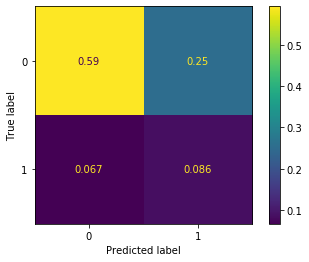

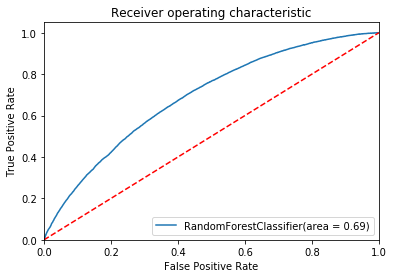

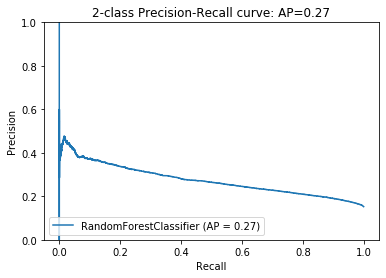

In [20]:
_ = best_random_forest_model.fit(X_traintest_transform, y_traintest.values)
random_forest_roc_auc = classifier_analysis(best_random_forest_model, X_holdout_transform, y_holdout.values)

In [21]:
best_random_forest_model.feature_importances_

array([2.29419798e-02, 3.97456882e-01, 3.08413206e-02, 5.67424377e-02,
       9.63478932e-02, 2.43513159e-02, 2.36007933e-02, 2.49240228e-02,
       2.81322977e-02, 1.55452329e-02, 1.86311111e-02, 1.32369807e-02,
       1.02497742e-02, 1.52795239e-02, 1.03234902e-02, 6.80443547e-03,
       4.31904129e-03, 3.72394808e-03, 4.80023650e-03, 5.73144389e-03,
       1.94131259e-03, 3.68138485e-03, 2.32679048e-03, 4.06603250e-03,
       3.92795777e-03, 2.65954167e-03, 2.67380646e-03, 3.36809229e-03,
       1.63479464e-03, 8.05846616e-04, 7.66648494e-04, 8.51002876e-04,
       4.65573336e-05, 7.86920269e-05, 2.44629252e-04, 5.75844017e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.62907911e-04,
       3.14326363e-03, 7.59007394e-04, 7.55539422e-04, 2.56222396e-04,
       5.50120434e-04, 4.20163202e-04, 4.18451695e-04, 3.87734148e-04,
       8.74533608e-04, 8.96711077e-03, 3.16645037e-02, 0.00000000e+00,
       0.00000000e+00, 9.93075728e-04, 1.50529444e-02, 1.24882480e-05,
      

In [22]:
class_weight = ['balanced']
C = [0.25, 1, 4]
max_iter = [250]
tol = [0.1, 0.01, 0.0001]
logistic_parameter_grid = { 'class_weight':class_weight,
                           'max_iter': max_iter,
                           'C':C,
                          'tol'= tol
                          'penalty'=pens}

SyntaxError: invalid syntax (<ipython-input-22-5b1b0bd32890>, line 8)

In [ ]:
best_logistic_regression_model = my_cross_validate(LogisticRegression, X_traintest, 
                                             y_traintest, train_test_iterable, logistic_parameter_grid, n_jobs=-2)

In [ ]:
best_logistic_regression_model

In [ ]:
_ = best_logistic_regression_model.fit(X_traintest_transform, y_traintest.values)
logistic_regression_roc_auc = classifier_analysis(best_logistic_regression_model, X_holdout_transform, y_holdout.values)

As can be seen, the logistic regression and random forest classification models seem to perform equally well. It has decent performance in regards to the main goal which is attempting to identify true positives. Originally the goal was to offer a recommendation for whether or not to provide the loan. Because there are
so many false positives, however, I do not believe that this is sufficiently accurate to determine whether or not to provide
loans, as it would reject far too many applicants. Therefore the best that this model can do is to flag accounts which
are at risk of defaulting. This is still a proactive measure but it would only be correct around 25% of the time. 

The surface level comparison is that the logistic regression predicts the "true" label more often than the random forest classification. As a result, there is a higher prevalance of true and false positives. This is evidenced by the increase in
both recall and precision of the logistic regression.

For a recommendation I believe more work needs to be done to see why so many false positives are predicted. But if I were forced to choose between the two current models, I think if I was minimized the amount of lost capital, I need to have more recall on the "1" label because this represents a defaulted loan. In other words, use the Logistic Regression, which produces more false positives to reduce the number of potentially defaulting loans.